In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import locale
from locale import atof

%config InlineBackend.figure_format = 'svg'
%matplotlib inline 

# Downloading and Cleaning Data

In [2]:
def all_saturdays(start_date, end_date):
    """ 
    Takes two dates and returns a list of saturdays between the first date and a week after the second date
  
    Parameters: 
    start_date (str): date formatted in M/D/YYYY
    end_date (str): date in M/D/YYYY
  
    Returns: 
    saturday_list (list): a list of Saturday dates
    """
    
    modified_end_date = datetime.datetime.strptime(end_date,'%m/%d/%Y')+ datetime.timedelta(weeks = 1)
    saturday_list = pd.date_range(start =start_date, end =modified_end_date,
                              freq='W-SAT').strftime('%m/%d/%Y').tolist()
    return saturday_list

In [3]:
def import_mta(date):
    """reads in MTA turnstile data published online for a given date"""
    formatted_date = date[-2:]+date[:2]+date[3:5]
    base_url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    date_url = base_url.format(formatted_date)
    date_data = pd.read_csv(date_url)
    return date_data

In [4]:
def mta_to_df(saturday_list):
    """imports MTA turnstile data for a list of dates and then concatenates them"""
    dict_of_dfs = {}
    for saturday in saturday_list:
        dict_of_dfs[saturday] = pd.DataFrame(import_mta(saturday))
    mta =pd.DataFrame()
    for val in dict_of_dfs.values():
        mta = pd.concat([mta, val])
    return mta

In [5]:
start_date = input("Enter start date (X/X/XXXX): ")
end_date = input("Enter end date (X/X/XXXX): ")

Enter start date (X/X/XXXX): 3/1/2019
Enter end date (X/X/XXXX): 6/1/2019


In [8]:
saturday_list = all_saturdays(start_date,end_date)

In [9]:
mta = mta_to_df(saturday_list)

In [10]:
mta.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
205006,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2019,17:00:00,RECOVR AUD,5554,379
205007,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2019,21:00:00,REGULAR,5554,379
205008,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/06/2019,01:00:00,REGULAR,5554,379
205009,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/06/2019,05:00:00,REGULAR,5554,379
205010,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/06/2019,09:00:00,REGULAR,5554,379


In [11]:
#In case of breakage later, saving the mta data to a csv file.
mta.to_csv(r'mta.csv')

In [12]:
#keep commented unless you need to reload data (avoids having to pull everything from the web again)
# mta = pd.read_csv('mta.csv')

## Cleaning Core MTA Turnstile Data

### Column Names

In [13]:
mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3062159 entries, 0 to 205010
Data columns (total 11 columns):
C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                 int64
EXITS                                                                   int64
dtypes: int64(2), obj

In [14]:
mta.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [15]:
#to create consistency for easier accessing
#takes leading and trailing spaces out of column names, makes them all lowercase, and replaces "/" with "_"
mta.columns = mta.columns.str.strip().str.lower().str.replace('/',"_")

In [16]:
mta.columns

Index(['c_a', 'unit', 'scp', 'station', 'linename', 'division', 'date', 'time',
       'desc', 'entries', 'exits'],
      dtype='object')

### Create Datetime Column From Date and Time

In [17]:
mta["datetime"] = pd.to_datetime(mta.date + " " + mta.time, format="%m/%d/%Y %H:%M:%S")

In [18]:
mta.head()

,c_a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112,2019-02-23 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125,2019-02-23 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199,2019-02-23 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248,2019-02-23 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,19:00:00,REGULAR,6956004,2359292,2019-02-23 19:00:00


### Filter to Previously Specified Dates

In [21]:
mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3062159 entries, 0 to 205010
Data columns (total 12 columns):
c_a         object
unit        object
scp         object
station     object
linename    object
division    object
date        object
time        object
desc        object
entries     int64
exits       int64
datetime    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 303.7+ MB


In [22]:
mta.date = pd.to_datetime(mta.date,format="%m/%d/%Y")

In [23]:
#keep only rows within specified start_date and end_date
mta = mta[(mta.date >= start_date)]
mta = mta[(mta.date <= end_date)]

In [25]:
mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2711716 entries, 36 to 204983
Data columns (total 12 columns):
c_a         object
unit        object
scp         object
station     object
linename    object
division    object
date        datetime64[ns]
time        object
desc        object
entries     int64
exits       int64
datetime    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 269.0+ MB


In [26]:
mta.drop(columns = ['time'], inplace = True)

In [27]:
mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2711716 entries, 36 to 204983
Data columns (total 11 columns):
c_a         object
unit        object
scp         object
station     object
linename    object
division    object
date        datetime64[ns]
desc        object
entries     int64
exits       int64
datetime    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 248.3+ MB


### Identifying and Managing Duplicates

In [28]:
#identify row duplicates to determine cause and if they need to be removed
(mta
 .groupby(["c_a", "unit", "scp", "station", "datetime"])
 .entries.count()
 .reset_index()
 .sort_values("entries", ascending=False)).head(50)

,c_a,unit,scp,station,datetime,entries
716178,N071,R013,00-06-00,34 ST-PENN STA,2019-04-20 08:00:00,2
2215449,R283,R221,00-00-01,167 ST,2019-04-16 04:00:00,2
1325112,N519,R461,00-03-01,B'WAY-LAFAYETTE,2019-03-26 13:00:00,2
1325111,N519,R461,00-03-01,B'WAY-LAFAYETTE,2019-03-26 09:00:00,2
535277,JFK03,R536,00-00-02,JFK JAMAICA CT1,2019-04-07 01:00:00,2
637616,N045,R187,01-00-00,81 ST-MUSEUM,2019-06-01 17:00:00,2
1325110,N519,R461,00-03-01,B'WAY-LAFAYETTE,2019-03-26 05:00:00,2
1325108,N519,R461,00-03-01,B'WAY-LAFAYETTE,2019-03-25 21:00:00,2
1325107,N519,R461,00-03-01,B'WAY-LAFAYETTE,2019-03-25 17:00:00,2
895018,N135,R385,01-03-01,ROCKAWAY BLVD,2019-03-31 13:00:00,2


In [29]:
#given row duplicates are not adding to the data and may cuase unwanted error,
#dropping one row from each pair of duplicate rows
mta.sort_values(["c_a", "unit", "scp", "station", "datetime"], inplace=True, ascending=False)
mta.drop_duplicates(subset=["c_a", "unit", "scp", "station", "datetime"], inplace=True)

In [30]:
#to confirm duplicates were dropped
(mta
 .groupby(["c_a", "unit", "scp", "station", "datetime"])
 .entries.count()
 .reset_index()
 .sort_values("entries", ascending=False)).head(10)

,c_a,unit,scp,station,datetime,entries
0,A002,R051,02-00-00,59 ST,2019-03-01 03:00:00,1
1807759,R141,R031,00-06-00,34 ST-PENN STA,2019-04-26 08:00:00,1
1807761,R141,R031,00-06-00,34 ST-PENN STA,2019-04-26 16:00:00,1
1807762,R141,R031,00-06-00,34 ST-PENN STA,2019-04-26 20:00:00,1
1807763,R141,R031,00-06-00,34 ST-PENN STA,2019-04-27 00:00:00,1
1807764,R141,R031,00-06-00,34 ST-PENN STA,2019-04-27 04:00:00,1
1807765,R141,R031,00-06-00,34 ST-PENN STA,2019-04-27 08:00:00,1
1807766,R141,R031,00-06-00,34 ST-PENN STA,2019-04-27 12:00:00,1
1807767,R141,R031,00-06-00,34 ST-PENN STA,2019-04-27 16:00:00,1
1807768,R141,R031,00-06-00,34 ST-PENN STA,2019-04-28 00:00:00,1


In [31]:
mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2711648 entries, 204983 to 36
Data columns (total 11 columns):
c_a         object
unit        object
scp         object
station     object
linename    object
division    object
date        datetime64[ns]
desc        object
entries     int64
exits       int64
datetime    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 248.3+ MB


## Incorporating MTA Subway Location Data 

### Loading and Cleaning MTA Subway Location Data

In [32]:
locations = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [33]:
# Creating a copy in case we need to revert
stored_for_errors = locations.copy()

In [34]:
#to create consistency for easier accessing
#takes leading and trailing spaces out of column names, makes them all lowercase, and replaces "/" with "_"
locations.columns = locations.columns.str.strip().str.lower().str.replace('/',"_").str.replace(' ', '_')

In [35]:
#the locations.stop_name column corresponds to the mta.station column
#modifying format of values to match the mta data
locations['stop_name'] = locations.stop_name.str.upper().str.strip()

In [36]:
#check for naming differences in the values of mta.station and locations.stop_name

cols_in_both = [val for val in mta.station if val in locations.stop_name]
cols_in_only_mta = [val for val in mta.station.unique() if val not in locations.stop_name.unique()]
cols_in_only_locations = [val for val in locations.stop_name.unique() if val not in mta.station.unique()]

In [37]:
#look at values unique to mta.station and compare with values unique to locations.stop_name below
print('Unique mta values', sorted(cols_in_only_mta))
print('Unique locationn values', sorted(cols_in_only_locations))

Unique mta values ['103 ST-CORONA', '116 ST-COLUMBIA', '137 ST CITY COL', '138/GRAND CONC', '14 ST-UNION SQ', '149/GRAND CONC', '14TH STREET', '15 ST-PROSPECT', '161/YANKEE STAD', '163 ST-AMSTERDM', '21 ST-QNSBRIDGE', '3 AV 138 ST', '3 AV-149 ST', '33 ST-RAWSON ST', '34 ST-HERALD SQ', '34 ST-HUDSON YD', '34 ST-PENN STA', '4 AV-9 ST', '40 ST LOWERY ST', '42 ST-BRYANT PK', '42 ST-PORT AUTH', '46 ST BLISS ST', '47-50 STS ROCK', '4AV-9 ST', '5 AVE', '57 ST-7 AV', '59 ST COLUMBUS', '61 ST WOODSIDE', '63 DR-REGO PARK', '66 ST-LINCOLN', '68ST-HUNTER CO', '72 ST-2 AVE', '74 ST-BROADWAY', '75 ST-ELDERTS', '8 ST-NYU', '81 ST-MUSEUM', '82 ST-JACKSON H', '85 ST-FOREST PK', '86 ST-2 AVE', '90 ST-ELMHURST', '96 ST-2 AVE', '9TH STREET', 'AQUEDUCT N.COND', 'AQUEDUCT RACETR', 'ASTORIA DITMARS', 'ATL AV-BARCLAY', "B'WAY-LAFAYETTE", 'BAY RIDGE-95 ST', 'BEDFORD PK BLVD', 'BEDFORD-NOSTRAN', 'BEVERLEY ROAD', 'BRIARWOOD', 'BROOKLYN BRIDGE', 'BUSHWICK AV', 'CANARSIE-ROCKAW', 'CENTRAL PK N110', 'CHRISTOPHER ST

In [38]:
#replace the string naming of location.stop_name to match that of mta.station

mta['station'].replace({"4AV-9 ST":"4 AV-9 ST",
                       'TWENTY THIRD ST':'23 ST',
                       'THIRTY THIRD ST':'33 ST'},
                                        inplace = True)

In [39]:
#replace the string naming of location.stop_name to match that of mta.station
locations['stop_name'].replace({" - ":"-",
                                "CENTER":"CTR",
                                "SQ-E TREMONT AV":"SQ",
                                " UNIVERSITY":"",
                                "PLAZA":"PZ",
                                "COLLEGE":"COL",
                                "STATION":"STA",
                                     },
                                         regex=True, inplace=True)

In [40]:
#replace the string naming of location.stop_name to match that of mta.station
locations['stop_name'].replace({"103 ST-CORONA PZ":"103 ST-CORONA",
                                "137 ST-CITY COL":"137 ST CITY COL",
                                "138 ST-GRAND CONCOURSE":"138/GRAND CONC",
                                "149 ST-GRAND CONCOURSE":"149/GRAND CONC",
                                "15 ST-PROSPECT PK":"15 ST-PROSPECT",
                                "161 ST-YANKEE STADIUM":"161/YANKEE STAD",
                                "163 ST-AMSTERDAM AV":"163 ST-AMSTERDM",
                                "21 ST-QUEENSBRIDGE":"21 ST-QNSBRIDGE",
                                "3 AV-138 ST":"3 AV 138 ST",
                                "40 ST":"40 ST LOWERY ST",
                                "42 ST-PORT AUTHORITY BUS TERMINAL":"42 ST-PORT AUTH",
                                "5 AV":"5 AVE",
                                "59 ST-COLUMBUS CIRCLE":"59 ST COLUMBUS",
                                "66 ST-LINCOLN CTR":"66 ST-LINCOLN",
                                "68 ST-HUNTER COL":"68ST-HUNTER CO",
                                "75 ST":"75 ST-ELDERTS",
                                "81 ST-MUSEUM OF NATURAL HISTORY":"81 ST-MUSEUM",
                                "82 ST-JACKSON HTS":"82 ST-JACKSON H",
                                "85 ST-FOREST PKWY":"85 ST-FOREST PK",
                                "90 ST-ELMHURST AV":"90 ST-ELMHURST",
                                "9 ST":"9TH STREET",
                                "AQUEDUCT-N CONDUIT AV":"AQUEDUCT N.COND",
                                "AQUEDUCT RACETRACK":"AQUEDUCT RACETR",
                                "ASTORIA-DITMARS BLVD":"ASTORIA DITMARS",
                                 'ATLANTIC AV-BARCLAYS CTR':'ATL AV-BARCLAY',
                                 'BEDFORD-NOSTRAND AVS':'BEDFORD-NOSTRAN',
                                 'BEVERLEY RD':'BEVERLEY ROAD',
                                 'BRIARWOOD-VAN WYCK BLVD':'BRIARWOOD',
                                 'BROADWAY-LAFAYETTE ST':"B'WAY-LAFAYETTE",
                                 '15 ST-PROSPECT PARK':'15 ST-PROSPECT',
                                 '47-50 STS CTR':'47-50 STS ROCK',
                                 'BEDFORD PARK BLVD':'BEDFORD PK BLVD',
                                 'BROOKLYN BRIDGE-CITY HALL':'BROOKLYN BRIDGE',
                                 'BUSHWICK AV-ABERDEEN ST':'BUSHWICK AV',
                                 'CANARSIE-ROCKAWAY PKWY':'CANARSIE-ROCKAW',
                                 'CENTRAL PARK NORTH (110 ST)':'CENTRAL PK N110',
                                 'CHRISTOPHER ST-SHERIDAN SQ':'CHRISTOPHER ST',
                                 'CLINTON-WASHINGTON AVS':'CLINTON-WASH AV',
                                 'CONEY ISLAND-STILLWELL AV':'CONEY IS-STILLW',
                                 'COURT ST':'COURT SQ-23 ST',
                                 'CROWN HTS-UTICA AV':'CROWN HTS-UTICA',
                                 'DELANCEY ST':'CROWN HTS-UTICA',
                                 'E 105 ST':'EAST 105 ST',
                                 "E 143 ST-ST MARY'S ST":"E 143/ST MARY'S",
                                 'EASTCHESTER-DYRE AV':'EASTCHSTER/DYRE',
                                 'EASTERN PKWY-BROOKLYN MUSEUM':'EASTN PKWY-MUSM',
                                 'FAR ROCKAWAY-MOTT AV': 'FAR ROCKAWAY',
                                 'FLATBUSH AV-BROOKLYN COL':'FLATBUSH AV-B.C',
                                 'FLUSHING-MAIN ST':'FLUSHING-MAIN',
                                 'FOREST AV':'FOREST AVE',
                                 'FOREST HILLS-71 AV':'FOREST HILLS 71',
                                 'FORT HAMILTON PKWY': 'FT HAMILTON PKY',
                                 'GRAND ARMY PZ':'GRAND ARMY PLAZ',
                                 'GRAND AV-NEWTOWN':'GRAND-NEWTOWN',
                                 'GRAND CENTRAL-42 ST':'GRD CNTRL-42 ST',
                                 'HARLEM-148 ST':'HARLEM 148 ST',
                                 'HOWARD BEACH-JFK AIRPORT':'HOWARD BCH JFK',
                                 'HOYT-SCHERMERHORN STS':'HOYT-SCHER',
                                 'HUNTERS POINT AV':'HUNTERS PT AV',
                                 'JAMAICA CTR-PARSONS/ARCHER':'JAMAICA CENTER',
                                 'JAMAICA-179 ST':'JAMAICA 179 ST',
                                 'JAMAICA-VAN WYCK':'JAMAICA VAN WK',
                                 'JAY ST-METROTECH':'JAY ST-METROTEC',
                                 'KEW GARDENS-UNION TPKE':'KEW GARDENS',
                                 'KINGSTON-THROOP AVS':'KINGSTON-THROOP',
                                 'KNICKERBOCKER AV':'KNICKERBOCKER',
                                 'LEXINGTON AV/53 ST':'LEXINGTON AV/53',
                                 'LEXINGTON AV/63 ST':'LEXINGTON AV/63',
                                 'MARBLE HILL-225 ST':'MARBLE HILL-225',
                                 'METS-WILLETS POINT':'METS-WILLETS PT',
                                 'MORRISON AV- SOUND VIEW':'MORISN AV/SNDVW',
                                 'MYRTLE-WILLOUGHBY AVS': 'MYRTLE-WILLOUGH',
                                 'MYRTLE-WYCKOFF AVS':'MYRTLE-WYCKOFF',
                                 'NORWOOD-205 ST': 'NORWOOD 205 ST',
                                 'OZONE PARK-LEFFERTS BLVD':'OZONE PK LEFFRT',
                                 'PARK PL': 'PARK PLACE',
                                 'QUEENS PZ':'QUEENS PLAZA',
                                 'ROCKAWAY PARK-BEACH 116 ST':'ROCKAWAY PARK B',
                                 'ROOSEVELT ISLAND':'ROOSEVELT ISLND',
                                 'SENECA AV':'SENECA AVE',
                                 'SMITH-9 STS':'SMITH-9 ST',
                                 'ST GEORGE':'ST. GEORGE',
                                 'VAN CORTLANDT PARK-242 ST':'V.CORTLANDT PK',
                                 'VERNON BLVD-JACKSON AV':'VERNON-JACKSON',
                                 'W 4 ST':'W 4 ST-WASH SQ',
                                 'W 8 ST-NY AQUARIUM':'W 8 ST-AQUARIUM',
                                 'WAKEFIELD-241 ST':'WAKEFIELD/241',
                                 'WTC CORTLANDT':'WTC-CORTLANDT',
                                 '4 AV':'4 AV-9 ST',
                                 'ESSEX ST':'DELANCEY/ESSEX',
                                 'JACKSON HTS-ROOSEVELT AV':'JKSN HT-ROOSVLT',
                                 'NEWKIRK PZ':'NEWKIRK PLAZA',
                                 'QUEENSBORO PZ':'QUEENSBORO PLZ',
                                 'SUTPHIN BLVD-ARCHER AV-JFK AIRPORT':'SUTPHIN-ARCHER',
                                 'SUTTER AV-RUTLAND RD':'SUTTER AV-RUTLD',
                                 'UNION SQ-14 ST':'14TH STREET',
                                 'WHITEHALL ST':'WHITEHALL S-FRY',
                                 'WOODSIDE-61 ST':'61 ST WOODSIDE',
                                '34 ST-11 AV':'34 ST-HUDSON YD',
                                'JAMAICA CTR':'JAMAICA CENTER',
                                '47-50 STS-ROCKEFELLER CTR':'47-50 STS ROCK',
                                'WEST FARMS SQ-E TREMONT AV':'WEST FARMS SQ',
                                 'WESTCHESTER SQ-E TREMONT AV':'WESTCHESTER SQ'
                               },
                                        inplace = True)

In [45]:
#merge mta and locations on station/stop_name and division to enable view of the stations within each borough
mta_locations = mta.merge(locations, left_on=['station', 'division'], right_on=['stop_name', 'division'], suffixes=('_left', '_right'))

In [46]:
mta_locations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3035617 entries, 0 to 3035616
Data columns (total 23 columns):
c_a                      object
unit                     object
scp                      object
station                  object
linename                 object
division                 object
date                     datetime64[ns]
desc                     object
entries                  int64
exits                    int64
datetime                 datetime64[ns]
station_id               int64
complex_id               int64
gtfs_stop_id             object
line                     object
stop_name                object
borough                  object
daytime_routes           object
structure                object
gtfs_latitude            float64
gtfs_longitude           float64
north_direction_label    object
south_direction_label    object
dtypes: datetime64[ns](2), float64(2), int64(4), object(15)
memory usage: 555.8+ MB


In [47]:
mta_locations.borough.value_counts()

M     1572844
Bk     768211
Q      433435
Bx     261127
Name: borough, dtype: int64

# Determing Which Boroughs WomenTechWomenYes Gala Attendees Occupy

In [ ]:
census = pd.read_csv('NYC Census Jan-09-2020.csv')

In [ ]:
#Remove Superfluous "Value Note" colums. Clean column data to be more readable
ccols = [c for c in census.columns if c.lower()[0:10] != "value note"]
census = census[ccols]
census.columns = census.columns.str.split(
    ')').str[0].str.lower().str.split('(').str[1].str.rsplit(' ', 1).str[0]
census.columns = ['borough', np.nan, 'nyc', 'bronx', 'brooklyn', 
                  'manhattan', 'queens', 'staten_island']

In [ ]:
#Transpose dataframe so that boroughs represent rows instead of columns.
census = census.set_index('borough').T
#Drop columns with only empty values
census = census.drop(np.nan)
census = census.dropna(axis='columns',thresh=2)

In [ ]:
#Choose columns most relevant to our interests and clean the data to be more easily analyzed
census.columns.str.strip()
census_cols = ['Population estimates, July 1, 2018,  (V2018)','Female persons, percent',
       'Households with a broadband Internet subscription, percent, 2014-2018',
       'Median household income (in 2018 dollars), 2014-2018',
       'Women-owned firms, 2012', 'All firms, 2012', 'Land area in square miles, 2010']
census_columns = ['population', 'perc_female', 'perc_broadband', 
                  'income_dol', 'womenfirms', 'allfirms', 'area']
census = census[census_cols]
census.columns = census_columns
values

In [ ]:
#Clean data from strings to numeric values
census.perc_female = census.perc_female.str.rstrip('%')
census.perc_broadband = census.perc_broadband.str.rstrip('%')
census.income_dol = census.income_dol.str.lstrip('$')
locale.setlocale(locale.LC_NUMERIC, '')
census = census.applymap(atof)
census.perc_female = census.perc_female / 100.0
census.perc_broadband = census.perc_broadband / 100.0

In [ ]:
#Create column for percentage of firms owned by women for easier visualization
census['womfirm_percent'] = census['womenfirms']/census['allfirms']
#Create column for population per square mile to assess density of people in each burrow
census['pop_persqmi'] = census['population']//census['area']

In [ ]:
#Define Plot styling
brand_blue = '#042263FF'
plt.style.use('default')
sns.despine()
sns.set_style('white')
sns.set_palette("Set2");

In [ ]:
boroughs = ['NYC (All Boroughs)', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

In [ ]:
#Visualize Women per Square Mile in the 5 boroughs to compare density of women per borough
plt.figure(figsize=(10,6))
plt.bar(boroughs, census['perc_female']*census['pop_persqmi'],color=brand_blue)
plt.title('Women per Square Mile', fontsize=20)
plt.xlabel('Borough', fontsize=15)
plt.ylabel('Number of Women', fontsize=15);

In [ ]:
#Plot Median Annual Income to identify areas with potential contributors
plt.figure(figsize=(10,6))
plt.bar(boroughs, census['income_dol'],color=brand_blue)
plt.xlabel('Borough', fontsize=15)
plt.title('Median Annual Income (in dollars)', fontsize=20)
plt.ylabel('Income', fontsize=15);

In [ ]:
#Plot Female-Owned Firms per Square Mile to identify regions with higher propensities of women interested in tech and career growth 
plt.figure(figsize=(10,6))
plt.bar(boroughs, census['womenfirms']/census['area'],color=brand_blue)
plt.xlabel('Borough', fontsize=15)
plt.title('Female-Owned Firms per Square Mile', fontsize=20)
plt.ylabel('Firms', fontsize=15);

In [ ]:
#Plot Homes with Broadband to identify regions with higher emphasis on technology
plt.figure(figsize=(10,6))
plt.bar(boroughs, census['perc_broadband']*100,color=brand_blue)
plt.ylim(70,90)
plt.xlabel('Borough', fontsize=15)
plt.title('Homes with Broadband', fontsize=20)
plt.ylabel('Percentage of Homes', fontsize=15);

# Calculating Daily & Hourly Entries Per Turnstile

In [50]:
# MTA entries are tabulated on a cummulative bases
# Number of entries on day n was determined by subtracting cummulative entries on day n from day n + 1
# Daily entries were stored in a new column, daily_entries

In [51]:
by_turnstile_date = mta_locations.groupby(['c_a', 'unit', 'scp', 'station', 'borough', mta_locations.datetime.dt.date])

In [52]:
mta_daily = by_turnstile_date['entries'].min().reset_index()

In [53]:
mta_daily.describe([.95,.997])

,entries
count,4.128440e+05
mean,4.475416e+07
std,2.199648e+08
min,0.000000e+00
50%,2.754058e+06
95%,1.174411e+08
99.7%,1.927261e+09
max,2.129446e+09


In [54]:
mta_daily['daily_entries'] = mta_daily.groupby(['c_a', 'unit', 'scp', 'station'])['entries'].diff().shift(-1)

In [55]:
mta_daily.describe([.95,.997])

,entries,daily_entries
count,4.128440e+05,4.084650e+05
mean,4.475416e+07,1.155409e+04
std,2.199648e+08,1.099893e+07
min,0.000000e+00,-2.071640e+09
50%,2.754058e+06,8.170000e+02
95%,1.174411e+08,3.017000e+03
99.7%,1.927261e+09,5.477216e+03
max,2.129446e+09,2.088502e+09


In [56]:
# Min values appear below 0, inferring negative entries into the turnstile
# Issues was discovered in the documentation above: turnstiles reset preiodically causing the cummulative entry count to reset to 0
# Subtracting day n from n + 1 in this case causes a negative number of reported entries 
# To manage, all negtaive daily_entrie values were removed
mta_daily = mta_daily[mta_daily.daily_entries >= 0]

In [57]:
# Beyond two standard deviations, the data appeared anomolous with daily_entries values over 2 billion
# To manage, values beyond two standard deviations on the upper end of the data were also removed

mta_daily = mta_daily[mta_daily.daily_entries < mta_daily.daily_entries.quantile(q =.997)]

In [58]:
mta_daily.describe()

,entries,daily_entries
count,4.029010e+05,402901.000000
mean,3.283646e+07,1065.509904
std,1.753646e+08,984.256364
min,0.000000e+00,0.000000
25%,5.308250e+05,286.000000
50%,2.676353e+06,827.000000
75%,7.104893e+06,1602.000000
max,2.115842e+09,5488.000000


In [60]:
mta_daily

,c_a,unit,scp,station,borough,datetime,entries,daily_entries
0,A002,R051,02-00-00,59 ST,Bk,2019-03-01,6962094,1528.0
1,A002,R051,02-00-00,59 ST,Bk,2019-03-02,6963622,741.0
2,A002,R051,02-00-00,59 ST,Bk,2019-03-03,6964363,541.0
3,A002,R051,02-00-00,59 ST,Bk,2019-03-04,6964904,1239.0
4,A002,R051,02-00-00,59 ST,Bk,2019-03-05,6966143,1481.0
...,...,...,...,...,...,...,...,...
412749,R730,R431,00-00-03,EASTCHSTER/DYRE,Bx,2019-05-27,539645843,412.0
412750,R730,R431,00-00-03,EASTCHSTER/DYRE,Bx,2019-05-28,539646255,1220.0
412751,R730,R431,00-00-03,EASTCHSTER/DYRE,Bx,2019-05-29,539647475,1287.0
412752,R730,R431,00-00-03,EASTCHSTER/DYRE,Bx,2019-05-30,539648762,1307.0


In [64]:
# A column, dow, was added to indicate the day of the week for analysis of subway traffic accross weekdays and weekends
mta_daily.datetime = pd.to_datetime(mta_daily.datetime,format="%Y/%m/%d")
mta_daily['dow'] = mta_daily.datetime.dt.day_name()
# Including dow_num for graphing order
mta_daily['dow_num'] = mta_daily.datetime.dt.dayofweek

## Hourly entries by station

In [65]:
# Similar to above but with the goal of calculating hourly entries per turnstile rather than daily
# Separate dataframes were crated for hourly and daily datasets to simplify the analysis

In [66]:
by_turnstile_time = mta_locations.groupby(['c_a', 'unit', 'scp', 'station', mta_locations.datetime])
mta_hourly = by_turnstile_time['entries'].min().reset_index()

In [67]:
# In order to maintain the full datetime column in the hourly dataframe a different method was used
# The entries were shifted one day so the same subtraction could occur without losing the date value in the datetime column
mta_hourly['y_entries'] = mta_hourly.entries.shift(1)
mta_hourly['hourly_entries'] = mta_hourly.entries - mta_hourly.y_entries

In [68]:
mta_hourly.describe()

,entries,y_entries,hourly_entries
count,2.438277e+06,2.438276e+06,2.438276e+06
mean,4.536010e+07,4.535948e+07,6.369295e+02
std,2.214910e+08,2.214889e+08,1.352122e+07
min,0.000000e+00,0.000000e+00,-2.116109e+09
25%,5.364220e+05,5.364220e+05,1.000000e+01
50%,2.750687e+06,2.750687e+06,7.400000e+01
75%,7.326426e+06,7.326421e+06,2.400000e+02
max,2.129448e+09,2.129448e+09,2.121185e+09


In [69]:
# Negative values and highest percentage of data were removed to avoid impact of system resets 
# and subtraction accross the last hour of one turnstile and first hour of another turnstile
mta_hourly = mta_hourly[mta_hourly.hourly_entries >= 0]

In [70]:
mta_hourly = mta_hourly[mta_hourly.hourly_entries < mta_hourly.hourly_entries.quantile(q =.99)]

In [71]:
mta_hourly.describe()

,entries,y_entries,hourly_entries
count,2.388186e+06,2.388186e+06,2.388186e+06
mean,3.323083e+07,3.323066e+07,1.641548e+02
std,1.763645e+08,1.763645e+08,2.161173e+02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.242880e+05,5.242880e+05,1.000000e+01
50%,2.647733e+06,2.647517e+06,7.400000e+01
75%,7.104805e+06,7.104640e+06,2.350000e+02
max,2.115843e+09,2.115843e+09,1.194000e+03


In [72]:
# A column, dow, was added to indicate the day of the week for analysis of subway traffic accross weekdays and weekends
mta_hourly['dow'] = mta_hourly.datetime.dt.day_name()

# Identifying The Top Stations Accross Each Burough

In [73]:
# To identify which stations within each burrow have the greatest amount of traffic, 
# summed daily entries for each station to obtain a total weekly entries column 
mta_daily['datetime'] = pd.to_datetime(mta_daily.datetime,format="%Y-%m-%d")
grouped_by_station_and_week = mta_daily.groupby(['station','borough', mta_daily.datetime.dt.week])['daily_entries'].agg([np.sum]).reset_index()
grouped_by_station_and_week = grouped_by_station_and_week.rename(columns={'datetime': 'week', 'sum':'weekly_entries'})
grouped_by_station_and_week

,station,borough,week,weekly_entries
0,1 AV,M,9,21275.0
1,1 AV,M,10,98353.0
2,1 AV,M,11,99814.0
3,1 AV,M,12,123991.0
4,1 AV,M,13,129199.0
...,...,...,...,...
5038,ZEREGA AV,Bx,18,16543.0
5039,ZEREGA AV,Bx,19,16435.0
5040,ZEREGA AV,Bx,20,14984.0
5041,ZEREGA AV,Bx,21,16125.0


In [74]:
boroughs_in_dataset = grouped_by_station_and_week.borough.unique()
boroughs_in_dataset

array(['M', 'Q', 'Bx', 'Bk'], dtype=object)

In [75]:
# Leveraged the mean of each stations weekly_entries to further identify which stations had highest traffic
grp_sta_wk_mean = grouped_by_station_and_week.groupby(['station', 'borough'])['weekly_entries'].agg(['mean'])
grp_sta_wk_mean = grp_sta_wk_mean.sort_values(by='mean', ascending=False).reset_index()
grp_sta_wk_mean = grp_sta_wk_mean.rename(columns = {'mean': 'mean_weekly_entries'})

In [113]:
# For each borough, only need a subset of the top stations based on client's objectives and consumer information
# Numbers decided by census data and client objectives were Manhattan = 6, Brooklyn = 1, Queens = 2

def identify_top_stations(data, borough_name):
    """Takes in the data set and specific borough of interest 
    and identifies the top subway stations based on mean weekly
    turnstile entries"""
    
    top_stations = data[(data.borough==borough_name)].sort_values(by='mean_weekly_entries', ascending=False)[:10]
    top_sta_list = [sta for sta in top_stations.station]
    return top_sta_list

top_bk = identify_top_stations(grp_sta_wk_mean, 'Bk')[1:2] #item in row zero is an error due to matching station names in manhattan and brooklyn. Removed after outside research. 
top_m = identify_top_stations(grp_sta_wk_mean, 'M')[:7]
top_m.remove('FULTON ST') #item in row zero is an error due to matching station names in manhattan and brooklyn. Removed after outside research. 
top_q = identify_top_stations(grp_sta_wk_mean, 'Q')[:2]
all_top_sta = top_bk + top_m + top_q 

### General Patterns For All Stations

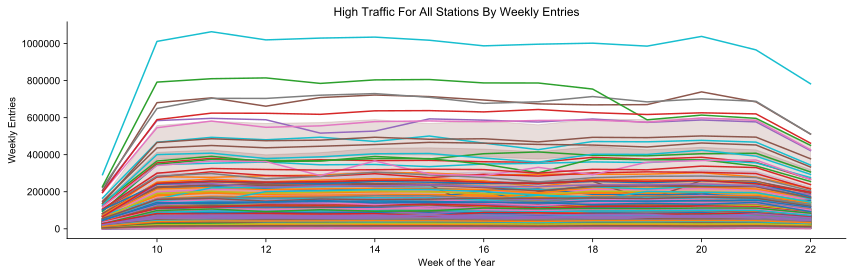

In [77]:
# Observe activity at all stations, not just top stations, to identify overarching patterns
plt.figure(figsize=(14,4))

unique_stations = grouped_by_station_and_week.station.unique()

for sta in unique_stations:
    single_station = grouped_by_station_and_week[grouped_by_station_and_week.station == sta]
    all_wk_all_sta_plot = sns.lineplot(x=single_station.week, y = single_station.weekly_entries)
    
all_wk_all_sta_plot.set_title('High Traffic For All Stations By Weekly Entries')
all_wk_all_sta_plot.set_ylabel('Weekly Entries')
all_wk_all_sta_plot.set_xlabel('Week of the Year')
sns.despine()
sns.set_style('white')
sns.set_palette("Set2");

/Users/mollyliebeskind/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


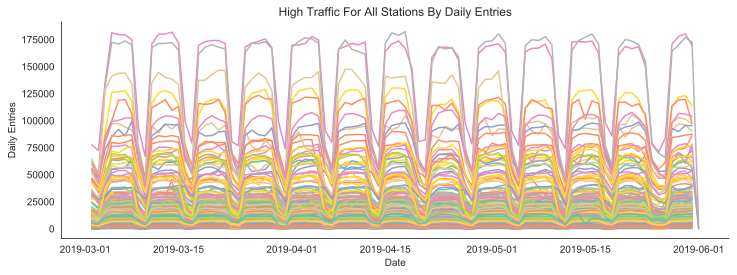

In [78]:
# Observe activity of all station on a daily bases to identify overarching patterns
grouped_by_station_and_day = mta_daily.groupby(['station', mta_daily.datetime.dt.date])['daily_entries'].agg([np.sum])
grouped_by_station_and_day = grouped_by_station_and_day.reset_index().rename(columns={'sum': 'daily_entries', 'datetime': 'date'})

plt.figure(figsize=(12,4))

for sta in unique_stations:
    single_station = grouped_by_station_and_day[grouped_by_station_and_day.station == sta]
    all_day_all_sta_plot = sns.lineplot(x=single_station.date[1:], y = single_station.daily_entries)
    
all_day_all_sta_plot.set_title('High Traffic For All Stations By Daily Entries')
all_day_all_sta_plot.set_ylabel('Daily Entries')
all_day_all_sta_plot.set_xlabel('Date')
sns.despine()
sns.set_style('white')
sns.set_palette("Set2");


### Traffic for Top Stations Specifically

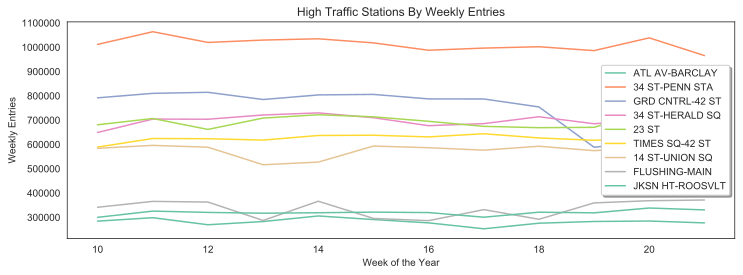

In [115]:
#Observe traffic by station for the most populated trains in each borough
plt.figure(figsize=(12,4))

for sta in all_top_sta:
    single_station = grouped_by_station_and_week[grouped_by_station_and_week.station == sta]
    time_plot = sns.lineplot(x=single_station.week[1:-1], y = single_station.weekly_entries, label=sta);
    
time_plot.legend(loc=0, fontsize='10', shadow=True);
time_plot.set_title('High Traffic Stations By Weekly Entries')
time_plot.set_ylabel('Weekly Entries')
time_plot.set_xlabel('Week of the Year');
sns.set_style('white')
sns.set_palette("Set2");

plt.savefig("High_Traffic_Stations_By_Weekly_Entries_Top_Sta.png")

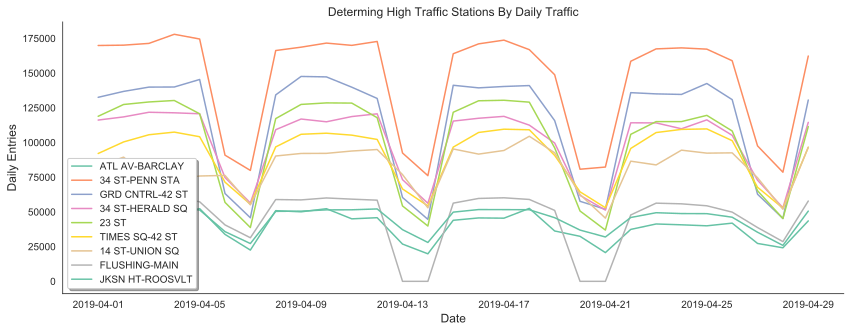

In [116]:
# Plot daily traffic for top trains for April only to more cleanly visualize patterns
plt.figure(figsize=(14,5))

for sta in all_top_sta:
    single_station = grouped_by_station_and_day[grouped_by_station_and_day.station == sta]
    ss_boundary = single_station[(single_station.date >= pd.to_datetime('2019-04-1').date()) & (single_station.date <= pd.to_datetime('2019-04-29').date())]
    time_plot = sns.lineplot(x=ss_boundary.date, y = ss_boundary.daily_entries, label=sta);
    
time_plot.legend(loc=3, fontsize='10', shadow=True);
time_plot.set_title('Determing High Traffic Stations By Daily Traffic', fontsize=12)
time_plot.set_ylabel('Daily Entries', fontsize=12)
time_plot.set_xlabel('Date', fontsize=12);
sns.despine()
sns.set_style('white')
sns.set_palette("Set2");

plt.savefig("Apr_Determing_high_traffic_stations_by_daily_traffic.png")

# Determining the Best Day of The Week to Deploy Street Teams

In [81]:
# Within the top stations identified above, determing which days of the week to deploy street taems to be economical with resources

In [117]:
grp_by_sta_dow = mta_daily.groupby(['station', 'dow', 'dow_num'])['daily_entries'].agg([np.mean]).reset_index()
grp_by_sta_dow = grp_by_sta_dow.rename(columns={'mean': 'mean_dow_entries'})

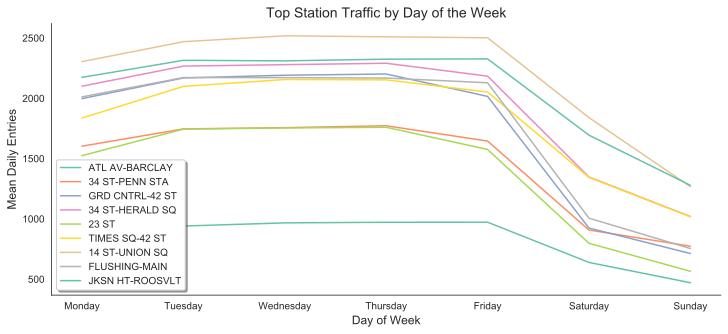

In [118]:
#Identify traffic by day of week for the top stations to determine optimal street team posting dates
plt.figure(figsize=(12,5))
    
days = ['','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
for sta in all_top_sta:
    single_station = grp_by_sta_dow[grp_by_sta_dow.station == sta].sort_values(by='dow_num')
    dow_plot = sns.lineplot(x=single_station.dow_num, y = single_station.mean_dow_entries, label=sta);
    
dow_plot.legend(fontsize='10', shadow=True, loc=3);
dow_plot.set_title('Top Station Traffic by Day of the Week', fontsize=14)
dow_plot.set_ylabel('Mean Daily Entries', fontsize=12)
dow_plot.set_xlabel('Day of Week', fontsize=12);
dow_plot.set_xticklabels(labels=days)

sns.despine()
sns.set_style('white')
sns.set_palette("Set2");

plt.savefig("Top_station_traffic_by_day_of_week.png")

# Determining the Best Time of Day to Deploy Street Teams

In [86]:
mta_hourly

,c_a,unit,scp,station,datetime,entries,y_entries,hourly_entries,dow
1,A002,R051,02-00-00,59 ST,2019-03-01 07:00:00,6962111,6.962094e+06,17.0,Friday
2,A002,R051,02-00-00,59 ST,2019-03-01 11:00:00,6962243,6.962111e+06,132.0,Friday
3,A002,R051,02-00-00,59 ST,2019-03-01 15:00:00,6962502,6.962243e+06,259.0,Friday
4,A002,R051,02-00-00,59 ST,2019-03-01 19:00:00,6963303,6.962502e+06,801.0,Friday
5,A002,R051,02-00-00,59 ST,2019-03-01 23:00:00,6963578,6.963303e+06,275.0,Friday
...,...,...,...,...,...,...,...,...,...
2437907,R730,R431,00-00-04,EASTCHSTER/DYRE,2019-03-28 05:00:00,1559996662,1.559997e+09,0.0,Thursday
2437997,R730,R431,00-00-04,EASTCHSTER/DYRE,2019-04-12 05:00:00,1559991102,1.559991e+09,0.0,Friday
2438057,R730,R431,00-00-04,EASTCHSTER/DYRE,2019-04-22 05:00:00,1559988012,1.559988e+09,0.0,Monday
2438157,R730,R431,00-00-04,EASTCHSTER/DYRE,2019-05-13 01:00:00,1559980024,1.559980e+09,0.0,Monday


In [122]:
#Narrowing the dataset to only the top stations to decrease amount of time needed for executions
x1, x2, x3, x4, x5, x6, x7, x8, x9 = all_top_sta
all_days_top_sta = mta_hourly[(mta_hourly.station == x1) |
                              (mta_hourly.station == x2) |
                              (mta_hourly.station == x3) |
                              (mta_hourly.station == x4) |
                              (mta_hourly.station == x5) |
                              (mta_hourly.station == x6) |
                              (mta_hourly.station == x7) |
                              (mta_hourly.station == x8) |
                              (mta_hourly.station == x9) 
                             ]

In [124]:
# Due to day light savings, some of the data has recordings at hours 0,4,8,12,16,20,24 while other data has recordings at hours 0,3,7,11,15,19,23
# Error causes various recordings to occur between the standard 4 hour increments 
# To account for hourly variations and daylight savings, grouping hourly data into 3 hour increments

hourly_dow = all_days_top_sta.groupby(['dow', all_days_top_sta.datetime.dt.hour])['hourly_entries'].agg(['mean']).reset_index()
hourly_dow = hourly_dow.rename(columns={'mean':'hourly_mean'})
def define_hour_groups(data):
    for row in data.index:
        if data.loc[row, 'datetime'] == 0:
            data.loc[row, 'hour_group'] = 0
        elif 0 < data.loc[row, 'datetime'] <= 3:
            data.loc[row, 'hour_group'] = 3
        elif 3 < data.loc[row, 'datetime']  <= 6:
            data.loc[row, 'hour_group'] = 6
        elif 6 < data.loc[row, 'datetime']  <= 9:
            data.loc[row, 'hour_group'] = 9
        elif 9 < data.loc[row, 'datetime']  <= 12:
            data.loc[row, 'hour_group'] = 12
        elif 12 < data.loc[row, 'datetime'] <= 15:
            data.loc[row, 'hour_group'] = 15
        elif 15 < data.loc[row, 'datetime']  <= 18:
            data.loc[row, 'hour_group'] = 18
        elif 18 < data.loc[row, 'datetime'] <= 21:
            data.loc[row, 'hour_group'] = 21
        elif 21 < data.loc[row, 'datetime'] <= 24:
            data.loc[row, 'hour_group'] = 24
    return data

hourly_dow = define_hour_groups(hourly_dow)

In [125]:
grp_hourly_dow = hourly_dow.groupby(['dow', 'hour_group'])['hourly_mean'].agg(['sum']).reset_index()
grp_hourly_dow = grp_hourly_dow.rename(columns = {'sum': 'entries_per_hour_group'})

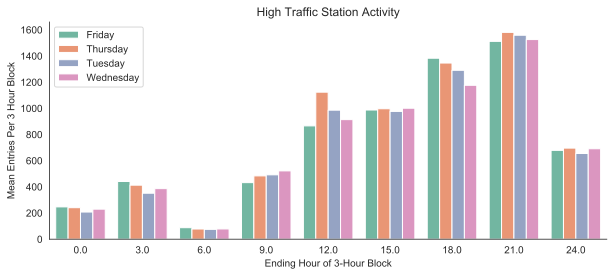

In [126]:
#plot hourly traffic for the busiest days of the week to determine posting times
days = ['Tuesday', 'Wednesday', 'Thursday', 'Friday']
peak_days = grp_hourly_dow[(grp_hourly_dow.dow == 'Tuesday') |
                       (grp_hourly_dow.dow == 'Wednesday') | 
                       (grp_hourly_dow.dow == 'Thursday') | 
                       (grp_hourly_dow.dow == 'Friday')  
                      ]
plt.figure(figsize=(10,4))
bar_time = sns.barplot(x=peak_days.hour_group, y = peak_days.entries_per_hour_group, hue=peak_days.dow);


bar_time.legend(fontsize='10', loc=2)
bar_time.set_title('High Traffic Station Activity')
bar_time.set_ylabel('Mean Entries Per 3 Hour Block')
bar_time.set_xlabel('Ending Hour of 3-Hour Block')
plt.savefig("Station_Traffic_By_Hour.png")
sns.despine()

plt.savefig("Peak_days_Station_Traffic_By_Hour.png")


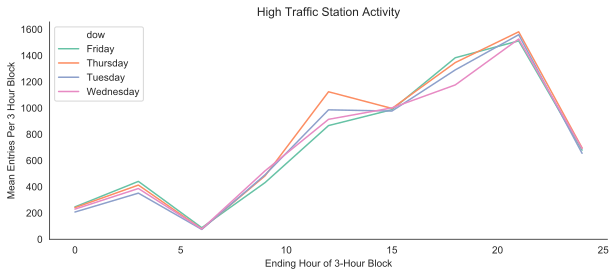

In [127]:
# Plotting same data as lineplot to compare visualization methods
days = ['Tuesday', 'Wednesday', 'Thursday', 'Friday']
peak_days = grp_hourly_dow[(grp_hourly_dow.dow == 'Tuesday') |
                       (grp_hourly_dow.dow == 'Wednesday') | 
                       (grp_hourly_dow.dow == 'Thursday') | 
                       (grp_hourly_dow.dow == 'Friday')  
                      ]
plt.figure(figsize=(10,4))
bar_time = sns.lineplot(x=peak_days.hour_group, y = peak_days.entries_per_hour_group, hue=peak_days.dow);


bar_time.legend(fontsize='10', loc=2)
bar_time.set_title('High Traffic Station Activity')
bar_time.set_ylabel('Mean Entries Per 3 Hour Block')
bar_time.set_xlabel('Ending Hour of 3-Hour Block')
plt.savefig("Station_Traffic_By_Hour.png")
sns.despine()

plt.savefig("Peak_days_Station_Traffic_By_Hour.png")

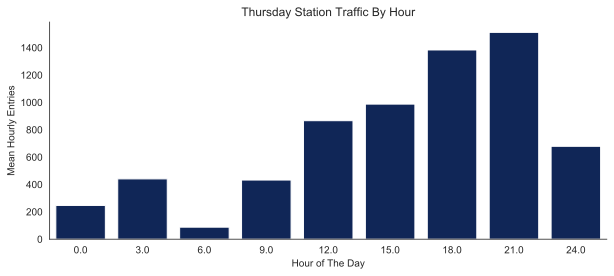

In [131]:
# Plotting for only Friday to compare visualization
thursday_hours = grp_hourly_dow[(grp_hourly_dow.dow == 'Thursday')]
plt.figure(figsize=(10,4))
bar_time = sns.barplot(x=single_day.hour_group, y = single_day.entries_per_hour_group, color='#042263FF');


bar_time.set_title('Thursday Station Traffic By Hour')
bar_time.set_ylabel('Mean Hourly Entries')
bar_time.set_xlabel('Hour of The Day')
sns.despine()

plt.savefig("Thursday_Station_Traffic_By_Hour.png")